<a href="https://colab.research.google.com/github/SamdeepSharma/Topsis-for-Pretrained-Models/blob/main/Text_Similarity_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# Installing necessary libraries and import them
#!pip install transformers torch scipy

import torch
import numpy as np
import pandas as pd
import csv
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# function to compute the cosine similarity between the embeddings of two texts using a transformer model.

def compute_text_similarity(model, tokenizer, text_a, text_b):

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else "[PAD]"

    tokens_a = tokenizer(text_a, return_tensors="pt", padding=True, truncation=True, max_length=128)
    tokens_b = tokenizer(text_b, return_tensors="pt", padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        emb_a = model(**tokens_a).last_hidden_state.mean(dim=1).squeeze()
        emb_b = model(**tokens_b).last_hidden_state.mean(dim=1).squeeze()

    return 1 - cosine(emb_a.numpy(), emb_b.numpy())

In [88]:
# function to rank models using the TOPSIS method

def apply_topsis(score_matrix, weight_array):
    # Step 1: Normalize scores
    norm_scores = score_matrix / np.sqrt(np.sum(score_matrix**2, axis=0))

    # Step 2: Apply weights (if any)
    weighted_scores = score_matrix * weight_array

    # Step 3: Determine ideal best and worst solutions
    ideal_best = np.max(weighted_scores, axis=0)
    ideal_worst = np.min(weighted_scores, axis=0)

    # Step 4: Compute distances from ideal best and worst
    dist_best = np.sqrt(np.sum((weighted_scores - ideal_best) ** 2, axis=1))
    dist_worst = np.sqrt(np.sum((weighted_scores - ideal_worst) ** 2, axis=1))

    # Step 5: Compute TOPSIS scores (Closeness coefficient)
    topsis_scores = dist_worst / (dist_best + dist_worst)

    return topsis_scores

In [89]:
# Define the transformer models to evaluate along with labels
model_dict = {
    "bert-base-uncased": "BERT",
    "roberta-base": "RoBERTa",
    "sentence-transformers/bert-base-nli-mean-tokens": "SBERT",
    "gpt2": "GPT-2",
    "distilbert-base-uncased": "DistilBERT",
    "distilroberta-base": "DistilRoBERTa",
}

# Define new, complex test sentences for evaluation
text_example_1 = (
    "Despite the ostensibly positive impact of artificial intelligence on productivity, its unchecked proliferation raises profound ethical dilemmas, particularly in the domains of data privacy and algorithmic bias."
)
text_example_2 = (
    "The paradox of technological progress lies in its dual potential: while fostering unprecedented efficiency, it simultaneously amplifies socio-economic disparities through automation-induced job displacement."
)

In [90]:
# Computing final results

sim_scores = []
model_names = []

# Loop over the defined models, compute similarity, and print the results
for model_key, label in model_dict.items():
    print(f"Evaluating model: {label} ...")

    # Load model and tokenizer
    transformer_model = AutoModel.from_pretrained(model_key)
    transformer_tokenizer = AutoTokenizer.from_pretrained(model_key)

    # Calculate similarity between the two texts
    score = compute_text_similarity(transformer_model, transformer_tokenizer, text_example_1, text_example_2)

    # Store the score and model label
    sim_scores.append(score)
    model_names.append(label)

    print(f"{label} Similarity Score: {score:.6f}")

# Prepare data for TOPSIS ranking
score_matrix = np.array(sim_scores).reshape(-1, 1)
weight_array = np.array([1])  # Using a single criterion

# Rank the models using TOPSIS
topsis_scores = apply_topsis(score_matrix, weight_array)

# Combine model names with their rankings and sort them
final_results = sorted(zip(model_names, topsis_scores), key=lambda x: x[1])

Evaluating model: BERT ...
BERT Similarity Score: 0.820232
Evaluating model: RoBERTa ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa Similarity Score: 0.989091
Evaluating model: SBERT ...
SBERT Similarity Score: 0.809956
Evaluating model: GPT-2 ...
GPT-2 Similarity Score: 0.996459
Evaluating model: DistilBERT ...
DistilBERT Similarity Score: 0.871826
Evaluating model: DistilRoBERTa ...
DistilRoBERTa Similarity Score: 0.991141


<ipython-input-91-78481fb5f459>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=sim_scores, x=model_names, palette="coolwarm")


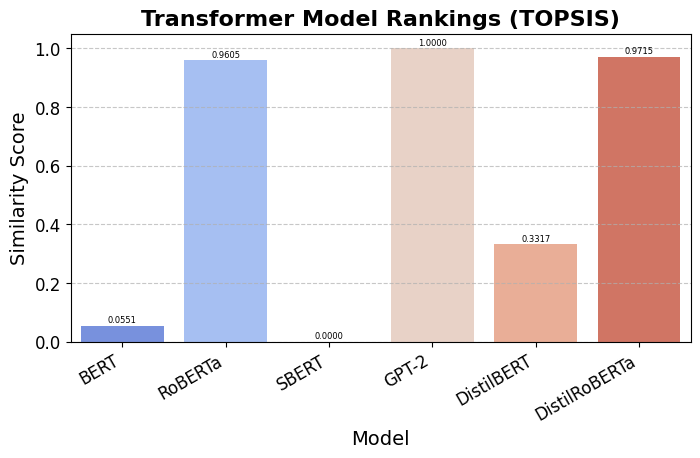

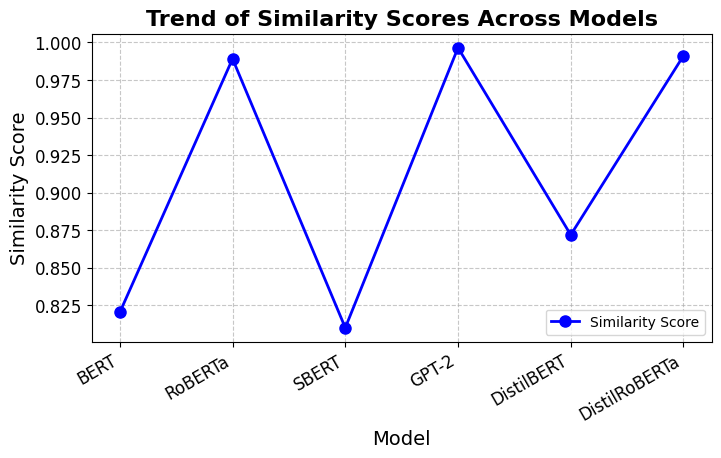

In [91]:
# Enhanced Bar Chart with Annotations
def plot_bar_chart(sim_scores, model_names):
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(y=sim_scores, x=model_names, palette="coolwarm")

    # Annotate each bar with its similarity score
    for i, score in enumerate(sim_scores):
        ax.text(i, score + 0.01, f"{score:.4f}", ha="center", fontsize=6, color="black")

    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Similarity Score", fontsize=14)
    plt.title("Transformer Model Rankings (TOPSIS)", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Enhanced Line Chart with Markers and Styling
def plot_line_chart(sim_scores, model_names):
    plt.figure(figsize=(8, 4))
    plt.plot(model_names, sim_scores, marker="o", linestyle="-", color="b", linewidth=2, markersize=8, label="Similarity Score")
    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Similarity Score", fontsize=14)
    plt.title("Trend of Similarity Scores Across Models", fontsize=16, fontweight="bold")
    plt.xticks(rotation=30, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

# Call the functions after computing results
plot_bar_chart(topsis_scores, model_names)
plot_line_chart(sim_scores, model_names)

In [92]:
# Rank the models based on normalized scores
topsis_ranking = pd.DataFrame({
    "Model": model_names,
    "TOPSIS_Score": topsis_scores,
    "Similarity_Score": sim_scores
})

# Sort by TOPSIS_Score in descending order and reset rank
topsis_ranking = topsis_ranking.sort_values(by="TOPSIS_Score", ascending=False)
topsis_ranking["Rank"] = range(1, len(topsis_ranking) + 1)

# Reorder columns so that 'Rank' comes first
topsis_ranking = topsis_ranking[["Model", "Rank", "TOPSIS_Score", "Similarity_Score"]]

print(topsis_ranking)

# Save to CSV
topsis_ranking.to_csv("model_topsis_rankings.csv", index=False)
print("Rankings saved to csv file.")

           Model  Rank  TOPSIS_Score  Similarity_Score
3          GPT-2     1      1.000000          0.996459
5  DistilRoBERTa     2      0.971484          0.991141
1        RoBERTa     3      0.960493          0.989091
4     DistilBERT     4      0.331740          0.871826
0           BERT     5      0.055099          0.820232
2          SBERT     6      0.000000          0.809956
Rankings saved to csv file.
